# Prior Predictive Checking

In [1]:
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import Predictive

RANDOM_SEED = 42
rng_key = random.PRNGKey(RANDOM_SEED)

ACTIVITIES = ["cycling", "picnic", "climbing", "movie"]


def model_vague_priors(obs=None):
    """A model with vague priors that don't incorporate domain knowledge.
    Using very high concentration leads to nearly uniform preferences.
    """
    # Vague prior: all activities equally likely with high certainty
    concentration = jnp.array([100.0, 100.0, 100.0, 100.0])
    theta = numpyro.sample("theta", dist.Dirichlet(concentration))
    numpyro.sample("obs", dist.Multinomial(total_count=25, probs=theta), obs=obs)


def model_informed_priors(obs=None):
    """A model with weakly informative priors that reflect domain knowledge.
    We expect some activities to be more popular than others, and preferences
    should show reasonable variation across users.
    """
    # Weakly informative prior: allows for varied preferences
    # Lower concentration values allow more variation in theta
    concentration = jnp.array([2.0, 2.0, 2.0, 2.0])
    theta = numpyro.sample("theta", dist.Dirichlet(concentration))
    numpyro.sample("obs", dist.Multinomial(total_count=25, probs=theta), obs=obs)


In [2]:
rng_key, subkey1, subkey2 = random.split(rng_key, 3)

prior_pred_vague = Predictive(model_vague_priors, num_samples=1000)
prior_samples_vague = prior_pred_vague(subkey1)

prior_pred_informed = Predictive(model_informed_priors, num_samples=1000)
prior_samples_informed = prior_pred_informed(subkey2)

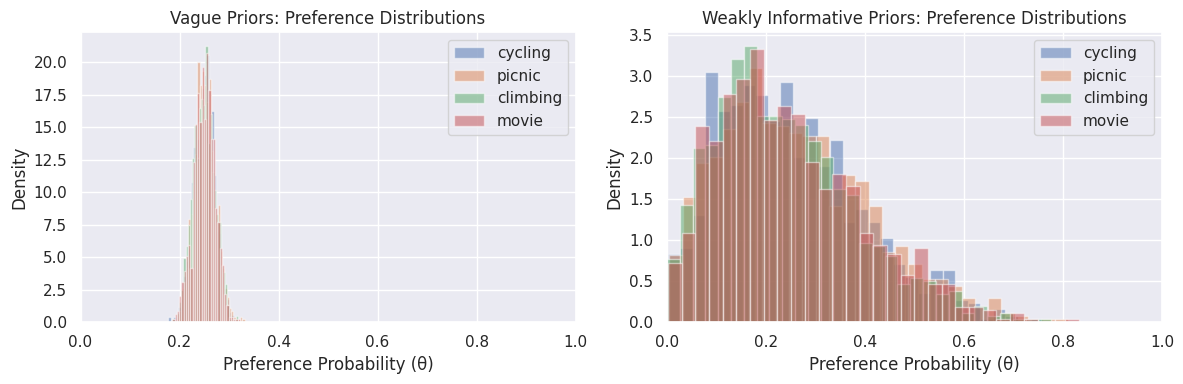

In [19]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

# Visualize prior predictive distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Vague priors - show theta distributions
for i, activity in enumerate(ACTIVITIES):
    axes[0].hist(
        prior_samples_vague["theta"][:, i],
        bins=30,
        alpha=0.5,
        label=activity,
        density=True,
    )
axes[0].set_xlabel("Preference Probability (θ)")
axes[0].set_ylabel("Density")
axes[0].set_title("Vague Priors: Preference Distributions")
axes[0].legend()
axes[0].set_xlim(0, 1)

# Informed priors - show theta distributions
for i, activity in enumerate(ACTIVITIES):
    axes[1].hist(
        prior_samples_informed["theta"][:, i],
        bins=30,
        alpha=0.5,
        label=activity,
        density=True,
    )
axes[1].set_xlabel("Preference Probability (θ)")
axes[1].set_ylabel("Density")
axes[1].set_title("Weakly Informative Priors: Preference Distributions")
axes[1].legend()
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

# Posterior Predictive Check

In [4]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive

RANDOM_SEED = 42
rng_key = random.PRNGKey(RANDOM_SEED)

ACTIVITIES = ["cycling", "picnic", "climbing", "movie"]
CONTEXTS = ["active+rainy", "active+sunny", "chill+rainy", "chill+sunny"]

# Observed data from user study (same as the previous lecture)
# Rows: contexts (mood × weather), Columns: activity counts
observed_data = jnp.array(
    [
        [0, 0, 15, 10],  # active & rainy: prefer indoor (climbing, movie)
        [15, 5, 0, 5],  # active & sunny: prefer outdoor (cycling)
        [0, 0, 5, 20],  # chill & rainy: strongly prefer movie
        [5, 15, 0, 5],  # chill & sunny: prefer relaxed outdoor (picnic)
    ]
)

mood = jnp.array([0, 0, 1, 1])  # 0=active, 1=chill
weather = jnp.array([0, 1, 0, 1])  # 0=rainy, 1=sunny


def hierarchical_preference_model(mood, weather, obs=None):
    """Hierarchical model for user activity preferences with context."""
    lam = numpyro.sample("lam", dist.Exponential(rate=1.0))

    beta_mood = numpyro.sample("beta_mood", dist.Exponential(rate=lam).expand((2, 4)))
    beta_weather = numpyro.sample(
        "beta_weather", dist.Exponential(rate=lam).expand((2, 4))
    )

    lam_0 = numpyro.sample("lam_0", dist.Exponential(rate=1.0))
    beta_0 = numpyro.sample("beta_0", dist.Exponential(rate=lam_0).expand((4,)))

    with numpyro.plate("context", 4):
        concentration = numpyro.deterministic(
            "concentration", beta_0 + beta_mood[mood, :] + beta_weather[weather, :]
        )
        theta = numpyro.sample("theta", dist.Dirichlet(concentration=concentration))
        numpyro.sample("obs", dist.Multinomial(total_count=25, probs=theta), obs=obs)


# Fit the model using MCMC
rng_key, subkey = random.split(rng_key)
kernel = NUTS(hierarchical_preference_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=1)
mcmc.run(subkey, mood=mood, weather=weather, obs=observed_data)

# Generate posterior predictive samples
posterior_samples = mcmc.get_samples()
predictive = Predictive(hierarchical_preference_model, posterior_samples)
rng_key, subkey = random.split(rng_key)
post_pred_samples = predictive(subkey, mood=mood, weather=weather, obs=None)

sample: 100%|██████████| 3000/3000 [00:02<00:00, 1181.50it/s, 31 steps of size 1.29e-01. acc. prob=0.93]


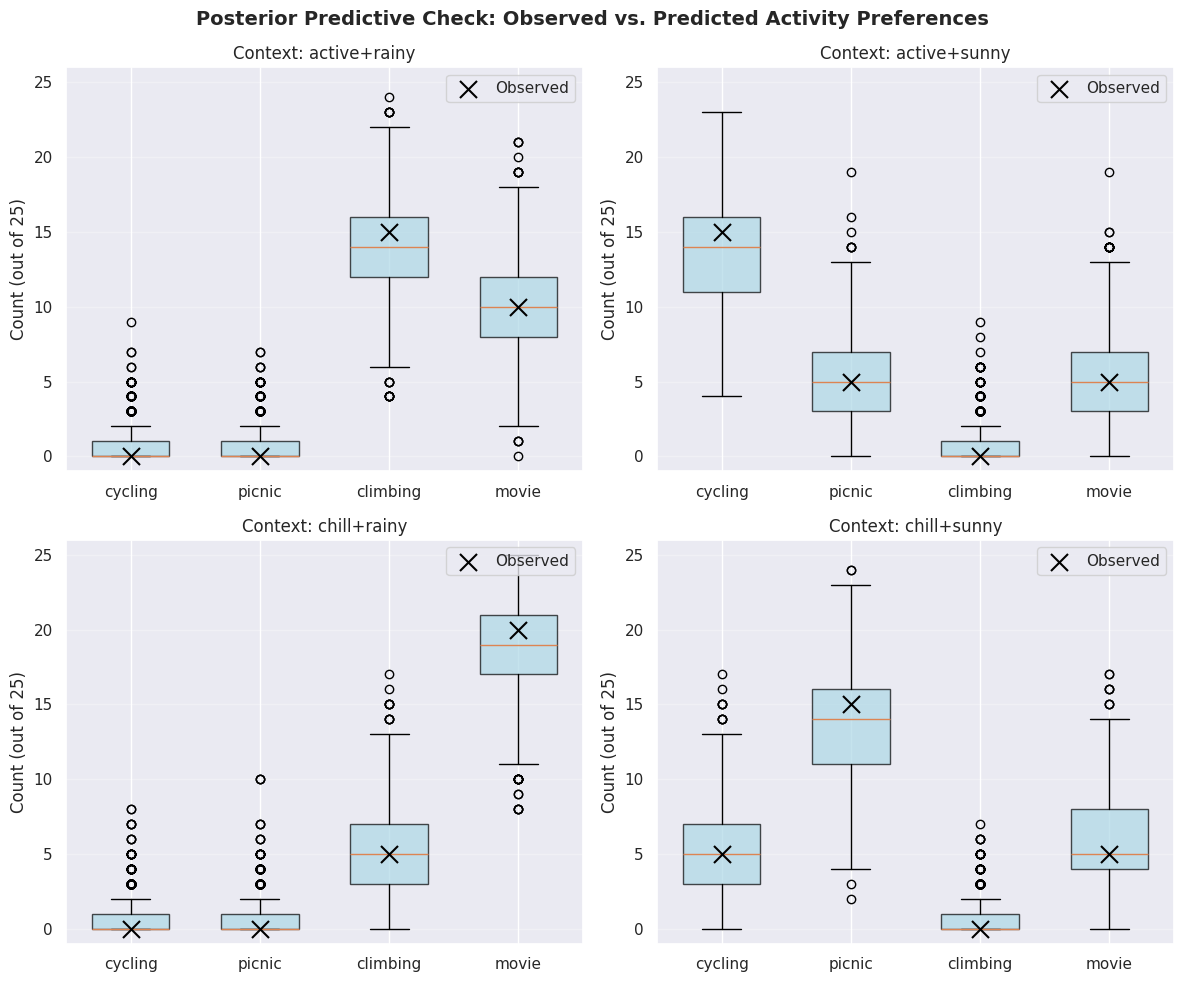

In [ ]:
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ctx_idx, (ax, ctx_name) in enumerate(zip(axes, CONTEXTS)):
    # Get posterior predictive samples for this context
    pp_samples = np.array(post_pred_samples["obs"][:, ctx_idx, :])  # (2000, 4)

    # Create boxplot data
    boxplot_data = [pp_samples[:, i] for i in range(4)]
    positions = np.arange(4)
    bp = ax.boxplot(boxplot_data, positions=positions, widths=0.6, patch_artist=True)

    # Style boxplots
    for patch in bp["boxes"]:
        patch.set_facecolor("lightblue")
        patch.set_alpha(0.7)

    # Overlay observed data points
    obs_values = np.array(observed_data[ctx_idx])
    ax.scatter(
        positions,
        obs_values,
        color="black",
        s=150,
        zorder=5,
        label="Observed",
        marker="x",  # circle marker
    )

    ax.set_xticks(positions)
    ax.set_xticklabels(ACTIVITIES)
    ax.set_ylabel("Count (out of 25)")
    ax.set_title(f"Context: {ctx_name}")
    ax.legend(loc="upper right")
    ax.set_ylim(-1, 26)
    ax.grid(axis="y", alpha=0.3)

plt.suptitle(
    "Posterior Predictive Check: Observed vs. Predicted Activity Preferences",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

# Cross-Validation

In [ ]:
idata = az.from_numpyro(
    mcmc,
    posterior_predictive=post_pred_samples,
    coords={"context": CONTEXTS, "activity": ACTIVITIES},
    dims={"theta": ["context", "activity"], "obs": ["context", "activity"]},
)

# Compute LOO-CV
loo_result = az.loo(idata, var_name="obs")
print(loo_result)

Computed from 2000 posterior samples and 4 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -23.60     1.85
p_loo        9.31        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        0    0.0%
   (0.70, 1]   (bad)         2   50.0%
   (1, Inf)   (very bad)    2   50.0%



/opt/conda/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [16]:
def simple_preference_model(mood, weather, obs=None):
    """A simpler model that ignores mood and weather context."""
    concentration = jnp.array([1.0, 1.0, 1.0, 1.0])
    theta = numpyro.sample("theta", dist.Dirichlet(concentration))

    with numpyro.plate("context", 4):
        numpyro.sample("obs", dist.Multinomial(probs=theta), obs=obs)


# Fit the simple model
rng_key, subkey = random.split(rng_key)
kernel_simple = NUTS(simple_preference_model)
mcmc_simple = MCMC(kernel_simple, num_warmup=1000, num_samples=2000, num_chains=1)
mcmc_simple.run(subkey, mood=mood, weather=weather, obs=observed_data)

# Generate posterior predictive for simple model
posterior_samples_simple = mcmc_simple.get_samples()
predictive_simple = Predictive(simple_preference_model, posterior_samples_simple)
rng_key, subkey = random.split(rng_key)
post_pred_simple = predictive_simple(subkey, mood=mood, weather=weather, obs=None)

# Create data for simple model
idata_simple = az.from_numpyro(
    mcmc_simple,
    posterior_predictive=post_pred_simple,
    coords={"context": CONTEXTS, "activity": ACTIVITIES},
    dims={"obs": ["context", "activity"]},
)

loo_simple = az.loo(idata_simple, var_name="obs")
print(loo_simple)

  0%|          | 0/3000 [00:00<?, ?it/s]

sample: 100%|██████████| 3000/3000 [00:01<00:00, 2618.58it/s, 7 steps of size 8.56e-01. acc. prob=0.89]


Computed from 2000 posterior samples and 4 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -317.02     2.65
p_loo       27.18        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        0    0.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    4  100.0%



/opt/conda/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [14]:
comparison = az.compare({"hierarchical": idata, "simple": idata_simple})
print(comparison)

              rank    elpd_loo      p_loo   elpd_diff  weight        se  \
hierarchical     0  -23.599530   9.312646    0.000000     1.0  1.845119   
simple           1 -317.189178  27.702393  293.589648     0.0  2.652683   

                   dse  warning scale  
hierarchical  0.000000     True   log  
simple        3.469056     True   log  


/opt/conda/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


# Evaluation with Test Data

In [ ]:
rng_key, subkey = random.split(rng_key)
test_data = jnp.array(
    [
        [1, 1, 13, 10],  # active & rainy
        [14, 6, 1, 4],  # active & sunny
        [0, 1, 6, 18],  # chill & rainy
        [4, 16, 1, 4],  # chill & sunny
    ]
)

# Use our fitted hierarchical model to make predictions and get predicted preferences
predictive = Predictive(
    hierarchical_preference_model, posterior_samples, return_sites=["obs", "theta"]
)
predictions = predictive(subkey, mood=mood, weather=weather, obs=None)
pred_theta = predictions["theta"]
pred_mean_theta = jnp.mean(pred_theta, axis=0)

# Convert test data to proportions for comparison
test_proportions = test_data / 25.0

# Calculate evaluation metrics
# Mean Absolute Error between predicted and observed proportions
mae = jnp.mean(jnp.abs(test_proportions - pred_mean_theta))

# Root Mean Square Error
rmse = jnp.sqrt(jnp.mean((test_proportions - pred_mean_theta) ** 2))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Per-context accuracy
print("\nPer-Context Evaluation:")
for ctx_idx, ctx_name in enumerate(CONTEXTS):
    ctx_mae = jnp.mean(jnp.abs(test_proportions[ctx_idx] - pred_mean_theta[ctx_idx]))
    print(f"  {ctx_name}: MAE = {ctx_mae:.4f}")

Evaluation Metrics on Test Data:
Mean Absolute Error (MAE): 0.0318
Root Mean Square Error (RMSE): 0.0393

Per-Context Evaluation:
  active+rainy: MAE = 0.0180
  active+sunny: MAE = 0.0294
  chill+rainy: MAE = 0.0226
  chill+sunny: MAE = 0.0570


In [ ]:
def recommend_activity(theta_samples):
    """Recommend the activity with highest expected utility."""
    mean_prefs = jnp.mean(theta_samples, axis=0)
    return jnp.argmax(mean_prefs)


# Get recommendations for each context
print("\nRecommendation Accuracy:")
for ctx_idx, ctx_name in enumerate(CONTEXTS):
    # Get model's recommendation
    rec_idx = recommend_activity(pred_theta[:, ctx_idx, :])
    recommended = ACTIVITIES[rec_idx]

    # Get ground truth (most preferred in test data)
    true_idx = jnp.argmax(test_data[ctx_idx])
    true_preferred = ACTIVITIES[true_idx]

    match = "✓" if rec_idx == true_idx else "✗"
    print(f"  {ctx_name}: Recommended={recommended}, Actual={true_preferred} {match}")


Recommendation Accuracy:
  active+rainy: Recommended=climbing, Actual=climbing ✓
  active+sunny: Recommended=cycling, Actual=cycling ✓
  chill+rainy: Recommended=movie, Actual=movie ✓
  chill+sunny: Recommended=picnic, Actual=picnic ✓


# Sensitivity Analysis

In [ ]:
def model_with_strong_pooling(mood, weather, obs=None):
    """Hierarchical model with stronger pooling (smaller lambda variance)."""
    lam = numpyro.sample("lam", dist.Exponential(rate=0.1))  # Larger lambda expected

    beta_mood = numpyro.sample("beta_mood", dist.Exponential(rate=lam).expand((2, 4)))
    beta_weather = numpyro.sample(
        "beta_weather", dist.Exponential(rate=lam).expand((2, 4))
    )

    lam_0 = numpyro.sample("lam_0", dist.Exponential(rate=1.0))
    beta_0 = numpyro.sample("beta_0", dist.Exponential(rate=lam_0).expand((4,)))

    with numpyro.plate("context", 4):
        concentration = numpyro.deterministic(
            "concentration", beta_0 + beta_mood[mood, :] + beta_weather[weather, :]
        )
        theta = numpyro.sample("theta", dist.Dirichlet(concentration=concentration))
        numpyro.sample("obs", dist.Multinomial(probs=theta), obs=obs)


def model_with_weak_pooling(mood, weather, obs=None):
    """Hierarchical model with weaker pooling (larger lambda variance)."""
    lam = numpyro.sample("lam", dist.Exponential(rate=5.0))  # Smaller lambda expected

    beta_mood = numpyro.sample("beta_mood", dist.Exponential(rate=lam).expand((2, 4)))
    beta_weather = numpyro.sample(
        "beta_weather", dist.Exponential(rate=lam).expand((2, 4))
    )

    lam_0 = numpyro.sample("lam_0", dist.Exponential(rate=1.0))
    beta_0 = numpyro.sample("beta_0", dist.Exponential(rate=lam_0).expand((4,)))

    with numpyro.plate("context", 4):
        concentration = numpyro.deterministic(
            "concentration", beta_0 + beta_mood[mood, :] + beta_weather[weather, :]
        )
        theta = numpyro.sample("theta", dist.Dirichlet(concentration=concentration))
        numpyro.sample("obs", dist.Multinomial(probs=theta), obs=obs)


# Fit both alternative models
models = {
    "original": hierarchical_preference_model,
    "strong_pooling": model_with_strong_pooling,
    "weak_pooling": model_with_weak_pooling,
}

results = {}
for name, model_fn in models.items():
    rng_key, subkey = random.split(rng_key)
    kernel = NUTS(model_fn)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=1)
    mcmc.run(subkey, mood=mood, weather=weather, obs=observed_data)
    results[name] = mcmc.get_samples()

# Compare posterior estimates for theta across models
print("Sensitivity Analysis: Comparing θ estimates across prior choices")
print("=" * 60)

for ctx_idx, ctx_name in enumerate(CONTEXTS):
    print(f"\nContext: {ctx_name}")
    for model_name, samples in results.items():
        theta_mean = jnp.mean(samples["theta"][:, ctx_idx, :], axis=0)
        print(f"  {model_name:15s}: {np.array(theta_mean).round(3)}")

sample: 100%|██████████| 3000/3000 [00:02<00:00, 1161.63it/s, 31 steps of size 1.74e-01. acc. prob=0.91]

Sensitivity Analysis: Comparing θ estimates across prior choices

Context: active+rainy
  original       : [0.024 0.021 0.552 0.404]
  strong_pooling : [0.015 0.014 0.57  0.401]
  weak_pooling   : [0.039 0.028 0.522 0.411]

Context: active+sunny
  original       : [0.551 0.209 0.024 0.216]
  strong_pooling : [0.565 0.202 0.015 0.217]
  weak_pooling   : [0.515 0.233 0.037 0.216]

Context: chill+rainy
  original       : [0.022 0.023 0.21  0.746]
  strong_pooling : [0.014 0.015 0.201 0.769]
  weak_pooling   : [0.029 0.037 0.231 0.703]

Context: chill+sunny
  original       : [0.213 0.543 0.02  0.224]
  strong_pooling : [0.202 0.567 0.014 0.217]
  weak_pooling   : [0.228 0.507 0.03  0.234]
